In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conway's Game of Life

While the concept of a cellular automaton (a model in which cells are updated based on the state of their neighbors) has been around for a while, Conway's Game of Life is the most famous example of such a system. It demonstrates quite clearly the way that very complex phenomena can emerge from simple local interactions, and has been studied extensively.

In Conway's Game of Life, a 2D square grid of cells are labelled as "alive" or "dead". Then, as the simulation progresses, the cell states flip between "dead" and "alive" depending on how many living cells surround them.

This automaton is a good place to start for a demonstration of pylattica because it shows a few of the fundamental features of the code.

Before we begin though, take a quick look at the [Wikipedia Article](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) for the Game of Life to understand what the model is.

In particular, note that the rules describing the game are simple:

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In this notebook, we will implement this model using pylattica and show some of the libarary's visualization capabilities.

To begin, we make a few key imports.

In [6]:
from pylattica.core import SynchronousRunner
from pylattica.discrete import PhaseSet
from pylattica.structures.square_grid import DiscreteGridSetup, SimpleSquare2DStructureBuilder

The first step toward running the Game of Life with pylattica is to implement the rules we found in the Wikipedia article in python.

This is accomplished using an object oriented programming approach. Specifically, we create a new class called a Controller that implements the update rule.

Before that though, let's just write out this logic very simply:

In [7]:
def update_state(old_state, neighboring_states):
    alive_neighbor_count = 0
    dead_neighbor_count = 0
    
    for state in neighboring_states:
        if state == "alive":
            alive_neighbor_count += 1
        else:
            # since all cells are either alive or dead, nothing else
            dead_neighbor_count += 1
    
    # Now, we can implement the rules in python logic:
    if old_state == "alive":
        if alive_neighbor_count < 2:
            return "dead"
        elif alive_neighbor_count == 2 or alive_neighbor_count == 3:
            return "alive"
        elif alive_neighbor_count > 3:
            return "dead"
    elif old_state == "dead":
        if alive_neighbor_count == 3:
            return "alive"
    
    return old_state
    

This is a bit verbose, but we've written it that way just to emphasize the direct mapping of logical statements here to the rules from the Wikipedia article. Let's try out some hypothetical situations:

In [8]:
print("alive cell, 2 dead, 2 alive neighbors:")
print("result:", update_state("alive", ["alive", "dead", "alive", "dead"]))
print("")
print("alive cell, 1 dead, 4 alive neighbors:")
print("result:", update_state("alive", ["alive", "alive", "alive", "alive"]))
print("")
print("dead cell, 1 dead, 3 alive neighbors:")
print("result:", update_state("dead", ["alive", "alive", "alive", "dead"]))

alive cell, 2 dead, 2 alive neighbors:
result: alive

alive cell, 1 dead, 4 alive neighbors:
result: dead

dead cell, 1 dead, 3 alive neighbors:
result: alive


The rule looks like it's working. Let's see how we can use pylattica to make this rule into a whole simulation.

## Setting Up A Simulation State

We know that Conway's Game of Life has cells that are either dead or alive. In the parlance of pylattica, these discrete states are referred to as "phases", and the record of possible phases in a given simulation is called the `PhaseSet`.

We can establish the list of possible phases by providing some human identifiable strings to the `PhaseSet` class.

In [9]:
phases = PhaseSet(["alive", "dead"])

Now that we have our phases, let's set up a square simulation with a random distribution of dead and alive sites.

In [10]:
setup = DiscreteGridSetup(phases)
starting_step = setup.setup_noise(59, phases.phases)

That's it! Now we can do a quick visualization to see what the simulation state looks like.

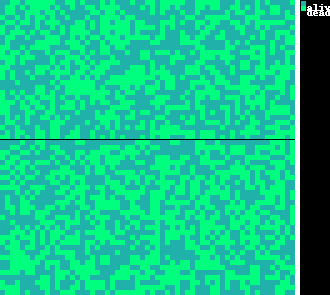

In [13]:
from pylattica.visualization import DiscreteSquareGridArtist2D

step_artist = DiscreteSquareGridArtist2D()
step_artist.jupyter_show(starting_step.state, cell_size=5)

## Inspecting the Simulation State

Before we continue, we have to understand structure of pylattica's simulation state. There are three core aspects to it:

1. A periodic structure
2. A simulation state dictionary
3. A neighborhood graph

#### Periodic Structure

Underlying the simulation state is an arrangement of sites. In our case, it is a two dimensional square grid (but in other simulations, it could be any type of lattice). This is called the "structure" of the simulation state. It is subject to periodic boundary conditions, meaning that a cell on the edge of the structure is a neighbor to the cell on the opposite edge of the grid.

Here's how we can view one of the sites in our structure.

In [14]:
starting_step.structure.sites()[0]

{'_site_class': '_A', '_location': (0.0, 0.0), '_site_id': 0}

Here are a few more. See how the locations are represented by two coordinates? They lie on a square grid.

In [15]:
print(starting_step.structure.sites()[1]['_location'])
print(starting_step.structure.sites()[2]['_location'])
print(starting_step.structure.sites()[23]['_location'])

(1.0, 0.0)
(2.0, 0.0)
(23.0, 0.0)


Every site in this structure has a `_site_class` of "_A". This is not significant. In other, more complex simulations, this attribute can be used to distinguish types of sites that exist in the structure. For instance, in materials science, we refer to lattice sites by their coordination structure (e.g. tetrahedral, octahedral).

#### Simulation State Dictionary

You may have noticed that the sites in our structure also have IDs. These IDs are referred to by the `SimulationState`. This object is essentially a dictionary that maps site IDs to the state of that site. A site state can be any arbitrary python dictionary, but in our case each site is just assigned an occupancy value. Let's make some sense of this.

The first site we have is (0,0). It's ID is 0 as well.

In [16]:
first_site = starting_step.structure.sites()[0]
print(f'Site {first_site["_site_id"]} is at {first_site["_location"]}')

Site 0 is at (0.0, 0.0)


Now let's see what it's state is:

In [17]:
starting_step.state.get_site_state(0)

{'_site_id': 0, 'DISCRETE_OCCUPANCY': 'alive'}

The `DISCRETE_OCCUPANCY` key indicates the "phase" that occupies that cell. Let's see if that lines up with our visualization. Remember, this site is at (0,0), or the bottom left of the simulation state.

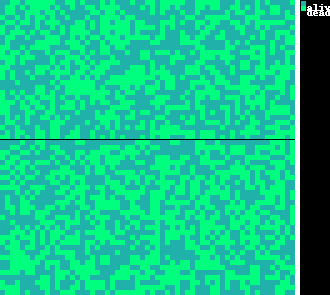

In [18]:
step_artist.jupyter_show(starting_step.state, cell_size=5)

Sure enough, that bottom left cell looks right!

#### Site Neighborhoods

The final ingredient to the pylattica model is the concept of a neighborhood. A neighborhood is simply the set of other sites that are considered neighbors. There are many different neighborhood specifications that are possible including classic neighborhoods for 2D square grids like [Moore Neighborhoods](https://en.wikipedia.org/wiki/Moore_neighborhood) and [Von Neumann Neighborhoods](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood).

You can specify neighborhoods in many different ways such as:

- All cells within a certain distance (actually Moore and Von Neumann neighborhoods both fall into this category, but with different distance cutoffs, or different distance metrics)
- All cells given by moving in a certain direction
- A random subset of surrounding cells

pylattica provides implementations for many common neighborhoods. As specified in the Game of Life Wikipedia article, we need a Moore neighborhood (includes the cells in each of the cardinal directions and the diagonal directions).

In [20]:
from pylattica.structures.square_grid import MooreNbHoodBuilder

To construct our neighborhood, we provide our state structure to a neighborhood builder. In this step, you can imagine the neighborhood builder visiting each site in the structure, and constructing a graph that specifies which sites are neighbors of every other site.

Here's how it works.

In [21]:
builder = MooreNbHoodBuilder()
nb_hood = builder.get(starting_step.structure)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3481/3481 [00:00<00:00, 15427.57it/s]


We can use the neighborhood to get the neighbors of any site, let's try the one at (5, 5).

In [22]:
site = starting_step.structure.site_at((5,5))
nbs = nb_hood.neighbors_of(site['_site_id'])

What do we expect the locations of these neighboring sites to be?

In [23]:
for nb_id in nbs:
    site = starting_step.structure.get_site(nb_id)
    print(f'Neighbor with ID {nb_id} is at {site["_location"]}')

Neighbor with ID 299 is at (4.0, 5.0)
Neighbor with ID 360 is at (6.0, 6.0)
Neighbor with ID 358 is at (4.0, 6.0)
Neighbor with ID 240 is at (4.0, 4.0)
Neighbor with ID 359 is at (5.0, 6.0)
Neighbor with ID 242 is at (6.0, 4.0)
Neighbor with ID 241 is at (5.0, 4.0)
Neighbor with ID 301 is at (6.0, 5.0)


As expected, these eight coordinate pairs correspond to the sites above, below, right and left, and diagonal of the site at (5, 5).

## Implementing the Simulation Controller

We've defined the possible states in our system, and initialized a starting point. The next step is move our update rule from before into a format the pylattica can understand. For this, we have to implement a new `Controller` class.

In [24]:
from pylattica.core import BasicController, SimulationState
from pylattica.discrete.state_constants import DISCRETE_OCCUPANCY
from pylattica.core.simulation_state import SITES

To accomplish this, we need to implement two methods in our controller class. The first, `pre_run` provides an opportunity to do any setup you'd like to before the simulation runs. It accepts as parameters the initial state of the simulation, and the structure underlying the state.

All we'll do is setup a neighborhood based on the structure that we can use later.

Second, we need to implement the `get_state_update` method. This is the fundamental piece of the controller. This method takes a site for which a new state should be calculated and the entire current simulation state. We can do any calculation we want to figure out the new state, but, armed with our neighborhood, and the update rule we implemented earlier, we have enough to create Conway's Game of Life.

In [29]:
def update_state(old_state, neighboring_states):
    alive_neighbor_count = 0
    dead_neighbor_count = 0
    
    for state in neighboring_states:
        if state == "alive":
            alive_neighbor_count += 1
        else:
            # since all cells are either alive or dead, nothing else
            dead_neighbor_count += 1
    
    # Now, we can implement the rules in python logic:
    if old_state == "alive":
        if alive_neighbor_count < 2:
            return "dead"
        elif alive_neighbor_count == 2 or alive_neighbor_count == 3:
            return "alive"
        elif alive_neighbor_count > 3:
            return "dead"
    elif old_state == "dead":
        if alive_neighbor_count == 3:
            return "alive"
        else:
            return "dead"
    
    return old_state

class GameOfLifeController(BasicController):
    
    def __init__(self, structure):
        self.structure = structure
    
    def pre_run(self, initial_state):
        # Before the simulation runs, we build a neighborhood based on the 
        # structure of the current simulation.
        self.neighborhood = MooreNbHoodBuilder().get(self.structure)
    
    def get_state_update(self, site_id, curr_state: SimulationState):
        neighbor_site_ids = self.neighborhood.neighbors_of(site_id)
        
        neighbor_states = []
        for nb_site_id in neighbor_site_ids:
            neighbor_state = curr_state.get_site_state(nb_site_id)
            neighbor_states.append(neighbor_state[DISCRETE_OCCUPANCY])

        current_state = curr_state.get_site_state(site_id)[DISCRETE_OCCUPANCY]
        
        new_state = update_state(current_state, neighbor_states)
        # print(site_id, current_state, neighbor_states, new_state)
        updates = {
            DISCRETE_OCCUPANCY: new_state
        }
        return updates
            

Finally, we instantiate our controller and a `Runner`, and let the simulation run for a few steps.

In [35]:
controller = GameOfLifeController(starting_step.structure)
runner = SynchronousRunner(parallel = True)
result = runner.run(starting_step.state, controller, 100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 167.82it/s]


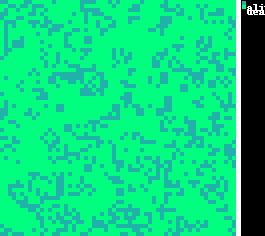

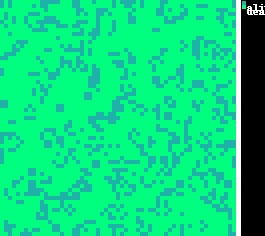

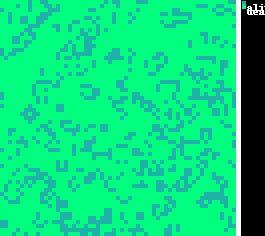

In [36]:
step_artist.jupyter_show(result.get_step(2), cell_size=4)
step_artist.jupyter_show(result.get_step(4), cell_size=4)
step_artist.jupyter_show(result.get_step(8), cell_size=4)

In [20]:
from pylattica.visualization import DiscreteSquareGridResultArtist
res_artist = DiscreteSquareGridResultArtist(step_artist, result)
res_artist.to_gif("out.gif", wait=0.1)